## **Load the Preprocessed Data**

First, you need to import the required libraries and load the `preprocessed_data.csv` file that you saved earlier.

In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
new_data = pd.read_csv(r"E:/Random Python Scripts/CICIDS/CICIDS2017/preprocessed_data.csv")

## **Prepare the Dataset for Binary Classification**

Next, create a balanced dataset for binary classification by separating normal traffic from intrusions, sampling them appropriately, and encoding the attack types.

In [2]:
# Creating a balanced dataset for Binary Classification
normal_traffic = new_data.loc[new_data['Attack Type'] == 'BENIGN']
intrusions = new_data.loc[new_data['Attack Type'] != 'BENIGN']

# Sample normal traffic to match the number of intrusions
normal_traffic = normal_traffic.sample(n=len(intrusions), replace=False)

# Concatenate intrusions and sampled normal traffic
ids_data = pd.concat([intrusions, normal_traffic])
ids_data['Attack Type'] = np.where((ids_data['Attack Type'] == 'BENIGN'), 0, 1)

# Sample a subset of the data for training/testing
bc_data = ids_data.sample(n=15000)

print(bc_data['Attack Type'].value_counts())

Attack Type
0    7525
1    7475
Name: count, dtype: int64


## **Split the Data into Features and Target**

Now, split your data into features (X) and target (y) for model training.


In [3]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X_bc = bc_data.drop('Attack Type', axis=1)
y_bc = bc_data['Attack Type']

# Train-test split
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size=0.25, random_state=0)

## **Logistic Regression (Binary Classification)**

**Parameters:**

`max_iter`: this parameter sets the maximum number of iterations for the solver to converge. The default value is set to 100. However, our model could not converge with only 100 iterations so we increased it to our desire.

`C`: This parameter is the regularization strength and controls the trade-off between fitting the training data well and avoiding overfitting. A smaller value of C specifies stronger regularization. We used a lower value for one model and higher value on other to see how the models perform in avoiding overfitting after placing high and low importance respectively.

`solver`: This parameter specifies the algorithm to use in the optimization problem when fitting the logistic regression model. There are several different solver algorithms available such as lbfgs, saga, liblinear and a few more. We went with 'saga' and 'sag' to train our models.

`random_state`: This is to ensure that the output is deterministic and can be reproduced.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 15000, solver = 'sag', C = 100, random_state = 0)
lr.fit(X_train_bc, y_train_bc)

cv_lr = cross_val_score(lr, X_train_bc, y_train_bc, cv = 5)
print('Logistic regression Model')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr)))
print(f'\nMean cross-validation score: {cv_lr.mean():.2f}')

Logistic regression Model

Cross-validation scores: 0.9253333333333333, 0.9337777777777778, 0.9355555555555556, 0.9235555555555556, 0.9324444444444444

Mean cross-validation score: 0.93


The **cross-validation scores** represent the accuracy of the **logistic regression** model on different subsets (folds) of the training dataset during a 5-fold cross-validation.

The **coefficients** and **intercept** of a logistic regression model define the decision boundary (or the hyperplane in high-dimensional space) used to classify the data.

- A **positive coefficient** means the feature increases the likelihood of the sample belonging to the positive class (here, `1` - malicious activity).
- A **negative coefficient** means the feature decreases that likelihood.

The intercept (`lr.intercept_`) is the model's bias term. It represents the base prediction when all feature values are zero. This value shifts the decision boundary.

In [6]:
print('Logistic Regression Model coefficients:')
print(*lr.coef_, sep = ', ')
print('\nLogistic Regression Model intercept:', *lr.intercept_)

Logistic Regression Model coefficients:
[-2.51412246e+01  3.69315985e-02  4.61303411e-01 -1.29198451e+00
 -4.90968348e-01  1.20635983e+00 -2.16442953e+00  2.57404215e+00
  2.07400256e+00 -1.90956280e-02  1.57252514e+00 -1.57042624e+00
 -1.66333177e+00  4.15764704e-01 -5.22862691e+00 -7.40994576e-01
  6.74791765e-01  3.21037201e+00 -2.74254055e+00  5.45234634e+00
 -1.55684867e+00  6.75797879e+00  1.88182330e+00  2.31384048e+00
 -3.09978509e-01 -3.75717895e+00  8.26508049e-01 -1.42426294e+00
 -6.35045769e+00  1.89105814e+00  4.45244902e+00 -1.07482346e+01
 -1.99655589e+01 -2.22904799e+00 -1.56519786e+00]

Logistic Regression Model intercept: -12.83490224204147


In [7]:
# Make predictions on the test set
y_pred_lr = lr.predict(X_test_bc)

# Generate classification report
report = classification_report(y_test_bc, y_pred_lr)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1903
           1       0.90      0.95      0.92      1847

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



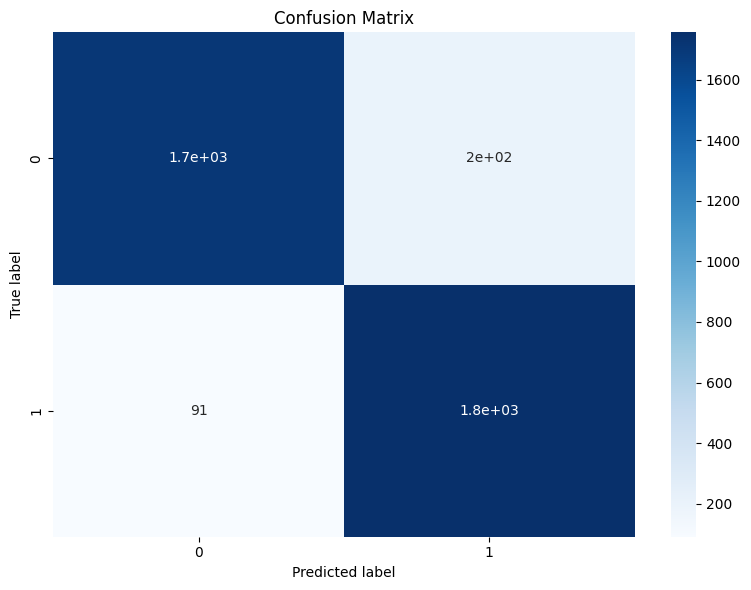

In [13]:
y_pred_lr = lr.predict(X_test_bc)

conf_matrix_model = confusion_matrix(y_test_bc, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

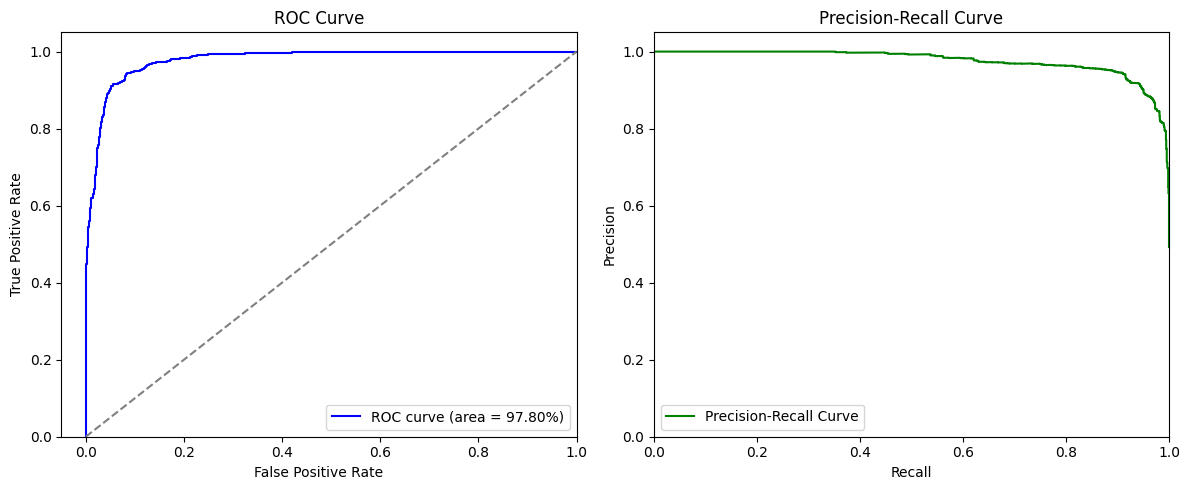

In [14]:
# Calculating probabilities and metrics for a single model
y_prob_lr = lr.predict_proba(X_test_bc)[:, 1] 

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bc, y_prob_lr)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_bc, y_prob_lr)

# Plotting both curves
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC Curve
axs[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2%})', color='blue')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve
axs[1].plot(recall, precision, color='green', label='Precision-Recall Curve')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the model to a file
model_filename = 'logistic_regression_model.joblib'
joblib.dump(lr, model_filename)

print(f'Model saved to {model_filename}')

In [ ]:
'''
# Load model through JobLib
# Load the model from the file
loaded_model = joblib.load(model_filename)

# Example of making predictions
predictions = loaded_model.predict(X_test_bc)
print(predictions)
'''

## **Support Vector Machine (Binary Classification)**

**Parameters:**
`kernel`: The kernel parameter specifies the type of kernel function to use. In this case, we have used rbf and poly kernel.

`C`: The C parameter controls the trade-off between maximizing the margin and minimizing the classification error.

`gamma`: The gamma parameter is a hyperparameter that determines the influence of a single training example on the decision boundary.

`random_state`: This is to ensure that the output is deterministic and can be reproduced.

In [15]:
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', C = 1, gamma = 0.1, random_state = 0, probability = True)
svm.fit(X_train_bc, y_train_bc)

cv_svm = cross_val_score(svm, X_train_bc, y_train_bc, cv = 5)
print('Support Vector Machine Model')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_svm)))
print(f'\nMean cross-validation score: {cv_svm.mean():.2f}')
print('SVM Model intercept:', *svm.intercept_)

Support Vector Machine Model

Cross-validation scores: 0.9555555555555556, 0.9635555555555556, 0.9666666666666667, 0.9662222222222222, 0.9666666666666667

Mean cross-validation score: 0.96
SVM Model intercept: -0.43986949908816997


In [16]:
# Make predictions on the test set
y_pred_svm = svm.predict(X_test_bc)

# Generate classification report
report = classification_report(y_test_bc, y_pred_svm)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1903
           1       0.95      0.97      0.96      1847

    accuracy                           0.96      3750
   macro avg       0.96      0.96      0.96      3750
weighted avg       0.96      0.96      0.96      3750



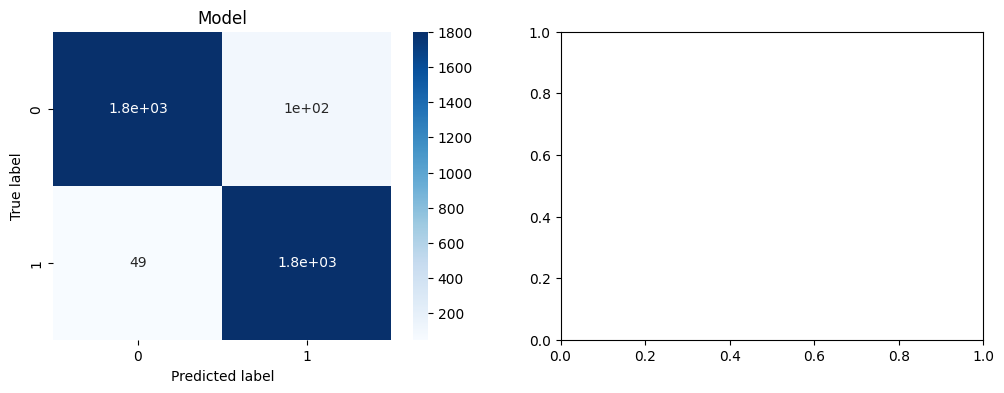

In [17]:
y_pred_svm = svm.predict(X_test_bc)

conf_matrix_model = confusion_matrix(y_test_bc, y_pred_svm)

fig, axs = plt.subplots(1, 2, figsize = (12, 4))

sns.heatmap(conf_matrix_model, annot = True, cmap = 'Blues', ax = axs[0])
axs[0].set_title('Model')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
plt.show()

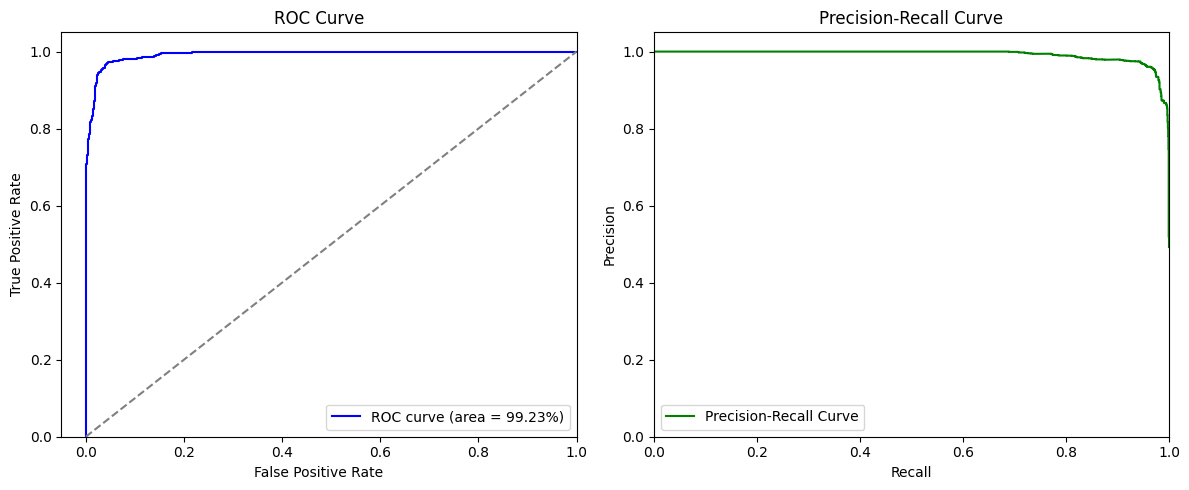

In [18]:
# Calculate probabilities and metrics for a single model
y_prob_svm = svm.predict_proba(X_test_bc)[:, 1]  # Use the probabilities predicted by the SVM model

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bc, y_prob_svm)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_bc, y_prob_svm)

# Plotting both curves
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC Curve
axs[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2%})', color='blue')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Plot Precision-Recall Curve
axs[1].plot(recall, precision, color='green', label='Precision-Recall Curve')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the SVM model to a file using joblib
svm_model_filename = 'svm_model.joblib'
joblib.dump(svm, svm_model_filename)

print(f'SVM model saved to {svm_model_filename}')

In [ ]:
'''
# Load the Model
# Load the SVM model from the file
loaded_svm = joblib.load(svm_model_filename)

# Example of making predictions
predictions = loaded_svm.predict(X_test_bc)
print(predictions)
'''

# **Performance Evaluation**

In [19]:
import pandas as pd
from sklearn.metrics import classification_report

# Make predictions & Generate classification report for Logistic Regression
y_pred_lr = lr.predict(X_test_bc)
report_lr = classification_report(y_test_bc, y_pred_lr, output_dict=True)

# Make predictions & Generate classification report for Support Vector Machine
y_pred_svm = svm.predict(X_test_bc)
report_svm = classification_report(y_test_bc, y_pred_svm, output_dict=True)

# Extract relevant metrics for both models
metrics_lr = report_lr['1']  
metrics_svm = report_svm['1'] 

# Create a DataFrame to compare models
comparison_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support'],
    'Logistic Regression': [metrics_lr['precision'], metrics_lr['recall'], metrics_lr['f1-score'], metrics_lr['support']],
    'Support Vector Machine': [metrics_svm['precision'], metrics_svm['recall'], metrics_svm['f1-score'], metrics_svm['support']]
})

# Calculate Accuracy for both models
accuracy_lr = (y_pred_lr == y_test_bc).mean()
accuracy_svm = (y_pred_svm == y_test_bc).mean()

# Add Accuracy to the DataFrame using pd.concat
accuracy_df = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Logistic Regression': [accuracy_lr],
    'Support Vector Machine': [accuracy_svm]
})

# Concatenate the accuracy DataFrame with the comparison DataFrame
comparison_df = pd.concat([comparison_df, accuracy_df], ignore_index=True)

# Display the comparison table
print("### Binary Classification Comparison Table ###")
print(comparison_df)

### Binary Classification Comparison Table ###
      Metric  Logistic Regression  Support Vector Machine
0  Precision             0.898210                0.946316
1     Recall             0.950731                0.973470
2   F1-Score             0.923724                0.959701
3    Support          1847.000000             1847.000000
4   Accuracy             0.922667                0.959733
